In [37]:
import pandas as pd
import plotly as px

In [38]:
def read_fixture(fixture: str, rule='T'):
    #Legge CSV
    df = pd.read_csv(f'./data/feed_{fixture}.MYD.csv', delimiter=' ', header=None, names=['date', fixture])
    df['date'] = pd.to_datetime(df['date'], unit='s')
    # Rinomina la colonna fixture in 'consumption'
    df.rename(columns={fixture: 'consumption'}, inplace=True)
    df.set_index('date', inplace=True)
    # Resample il DataFrame usando la frequenza specificata (minutale 'T')
    df_minutely = df.resample(rule).sum()
    
    # Ora raggruppiamo i dati minutali in giornate
    df_daily = df_minutely.resample('D').sum()
    
    # Creare un range di date da 2019-02-11 a 2019-02-17
    # Creare un range di date da 2019-02-18 a 2019-02-24
    date_rng = pd.date_range(start='2019-02-18', end='2019-02-24', freq='D')
    
    # Creare un DataFrame vuoto con il range di date specificato
    df_final = pd.DataFrame(date_rng, columns=['date'])
    df_final.set_index('date', inplace=True)
    
    # Unire il DataFrame giornaliero con il DataFrame vuoto per assicurarsi che tutte le date siano presenti
    df_final = df_final.join(df_daily, how='left').fillna(0)
    
    return df_final

In [39]:
def range_plot(df):
    fig = px.line(df, y='consumption', labels={'consumption': 'Volume [L]'})
    fig.update_xaxes()
    fig.update_yaxes(fixedrange=False)
    fig.update_layout(font=dict(size=22))#grandezza font
    fig.show()

,consumption
date,
2019-02-18,8773.0
2019-02-19,11962.0
2019-02-20,23821.0
2019-02-21,7761.0
2019-02-22,15156.0
2019-02-23,8121.0
2019-02-24,6905.0


<Axes: xlabel='date'>

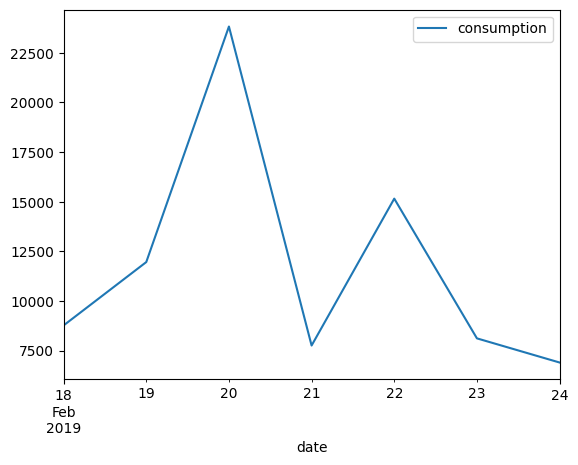

In [40]:
df_washbasin = read_fixture('Washbasin')
display(df_washbasin)
df_washbasin.plot()